## Setup

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import numpy as np
import json
from codellmeditor.models.agrace import MLPEncoder
from pathlib import Path
from tqdm import tqdm
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d
from codellmeditor.models.agrace import MLPEncoder
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from scipy.spatial.distance import euclidean

/home/hello/miniconda3/envs/clme/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/hello/miniconda3/envs/clme/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
datasets = json.load(open("./data/data_loo_1/EditConala/test.json"))

[711, 991, 1433]
rephrase_prompt_repr : 8.90715217590332
loc_prompts_reprs: 4.662002086639404
rephrase_prompt_repr : 18.73165512084961
loc_prompts_reprs: 5.360020637512207
rephrase_prompt_repr : 13.270779609680176
loc_prompts_reprs: 11.94941234588623


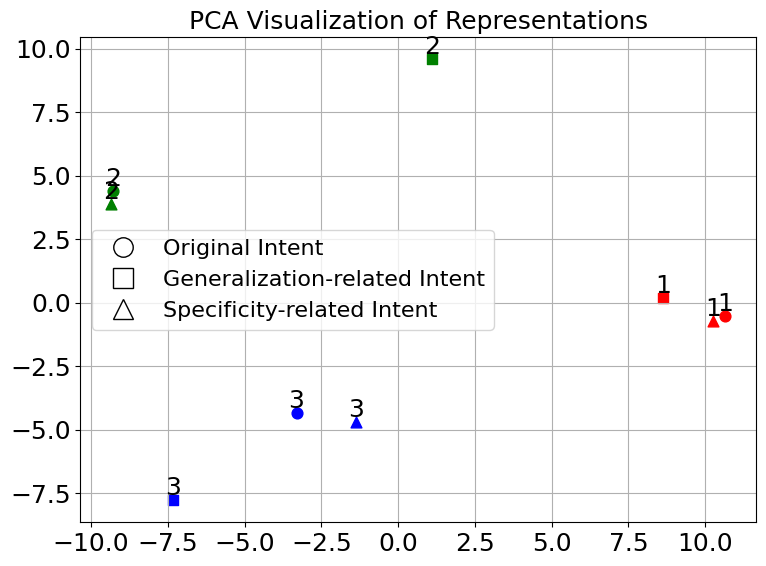

In [4]:
file_name = "./results/agrace_encoder_data/EditConala/CodeLlama-7b-hf_test_last_token.pkl"

with open(file_name, 'rb') as f:
    datas = torch.load(f)
    
sample_size = 1
sampled_data = np.random.choice(np.arange(len(datas)), size=sample_size, replace=False)
print(sampled_data)

plot_datas = [datas[i] for i in sampled_data]
plt.figure(figsize=(8, 6))
plt.rcParams.update({'font.size': 18})
colors = ['r', 'g', 'b']
markers = ['o', 's', '^']

prompt_reprs = []
rephrase_prompt_reprs = []
loc_prompts_reprs = []
distances_rewritten = []
distances_neighbor = []

for idx, data in enumerate(plot_datas):
    prompt_repr = np.array(data['prompt_repr'])
    rephrase_prompt_repr = np.array(data['rephrase_prompt_repr'])
    loc_prompts_repr = np.array(data['loc_prompts_reprs'][0])
    distance_rewritten = euclidean(prompt_repr, rephrase_prompt_repr)
    distance_neighbor = euclidean(prompt_repr, loc_prompts_repr)
    print(f"rephrase_prompt_repr : {distance_rewritten}")
    print(f"loc_prompts_reprs: {distance_neighbor}")

    prompt_reprs.append(prompt_repr)
    rephrase_prompt_reprs.append(rephrase_prompt_repr)
    loc_prompts_reprs.append(loc_prompts_repr)

    # 将向量组合成一个矩阵
reprs = prompt_reprs + rephrase_prompt_reprs + loc_prompts_reprs
data_matrix = np.array(reprs)

# 使用PCA进行降维
pca = PCA(n_components=2)
data_pca = pca.fit_transform(data_matrix)


for i in range(3):
    for k in range(i*sample_size, (i+1)*sample_size):
            plt.scatter(data_pca[k, 0], data_pca[k, 1], color=colors[k%3], s=60,  marker=markers[i])
            plt.text(data_pca[k, 0], data_pca[k, 1], f'{k%sample_size+1}',ha='center', va='bottom')

# 创建自定义图例
handles = [
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='w', markersize=14, markeredgecolor='k'),
    plt.Line2D([0], [0], marker='s', color='w', markerfacecolor='w', markersize=14, markeredgecolor='k'),
    plt.Line2D([0], [0], marker='^', color='w', markerfacecolor='w', markersize=14, markeredgecolor='k'),
]
labels = [
    'Original Intent', 'Generalization-related Intent', 'Specificity-related Intent',
]
plt.title('PCA Visualization of Representations', fontsize=18)
# plt.xlabel('Principal Component 1', fontsize=14)
# plt.ylabel('Principal Component 2', fontsize=14)
plt.legend(handles=handles, labels=labels, fontsize=16, loc='best', ncol=1)
plt.grid(True)
plt.tight_layout()
plt.savefig("last_token_PCA.pdf")

rephrase_prompt_repr : 0.13739275932312012
loc_prompts_reprs: 0.4583045244216919
rephrase_prompt_repr : 0.1346970945596695
loc_prompts_reprs: 0.23520733416080475
rephrase_prompt_repr : 0.1955961436033249
loc_prompts_reprs: 0.6996764540672302


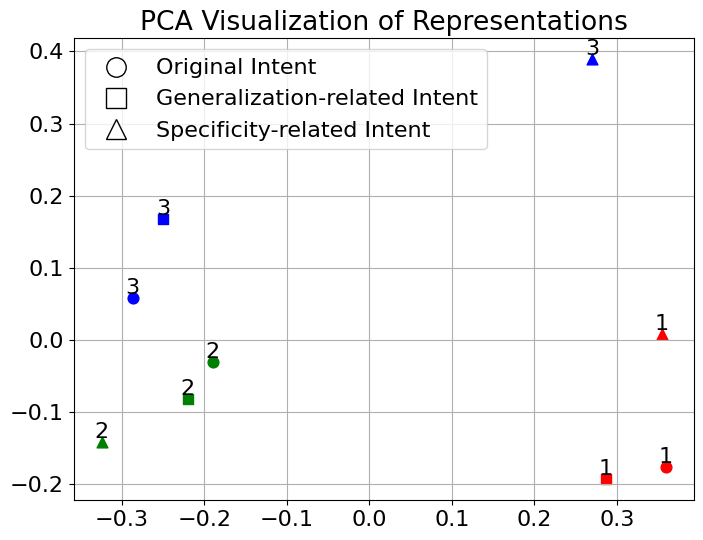

In [5]:
file_name = "./results/agrace_encoder_data/EditConala/CodeLlama-7b-hf_test_mean.pkl"
with open(file_name, 'rb') as f:
    datas = torch.load(f)

encoder_state_path = f"./results/agrace_encoder_data/EditConala/CodeLlama-7b-hf_model.layers.27.mlp.down_proj_train_eparam.pt"
encoder = MLPEncoder(datas[0]['prompt_repr'].shape[0], 256)
encoder.load_state_dict(torch.load(encoder_state_path))
encoder.eval()
plot_datas = [datas[i] for i in sampled_data]

plt.figure(figsize=(8, 6))
plt.rcParams.update({'font.size': 16})
colors = ['r', 'g', 'b']
markers = ['o', 's', '^']

prompt_reprs = []
rephrase_prompt_reprs = []
loc_prompts_reprs = []

for idx, data in enumerate(plot_datas):
    with torch.no_grad():
        prompt_repr = np.array(encoder(data['prompt_repr']))
        rephrase_prompt_repr = np.array(encoder(data['rephrase_prompt_repr']))
        loc_prompts_repr = np.array(encoder(data['loc_prompts_reprs'][0]))
        distance_rewritten = euclidean(prompt_repr, rephrase_prompt_repr)
        distance_neighbor = euclidean(prompt_repr, loc_prompts_repr)
        print(f"rephrase_prompt_repr : {distance_rewritten}")
        print(f"loc_prompts_reprs: {distance_neighbor}")

    prompt_reprs.append(prompt_repr)
    rephrase_prompt_reprs.append(rephrase_prompt_repr)
    loc_prompts_reprs.append(loc_prompts_repr)

    # 将向量组合成一个矩阵
reprs = prompt_reprs + rephrase_prompt_reprs + loc_prompts_reprs
data_matrix = np.array(reprs)

# 使用PCA进行降维
pca = PCA(n_components=2)
data_pca = pca.fit_transform(data_matrix)


for i in range(3):
  for k in range(i*sample_size, (i+1)*sample_size):
        plt.scatter(data_pca[k, 0], data_pca[k, 1], color=colors[k%3], s=60,  marker=markers[i])
        plt.text(data_pca[k, 0], data_pca[k, 1], f'{k%sample_size+1}',ha='center', va='bottom')

# 创建自定义图例
handles = [
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='w', markersize=14, markeredgecolor='k'),
    plt.Line2D([0], [0], marker='s', color='w', markerfacecolor='w', markersize=14, markeredgecolor='k'),
    plt.Line2D([0], [0], marker='^', color='w', markerfacecolor='w', markersize=14, markeredgecolor='k'),
]
labels = [
    'Original Intent', 'Generalization-related Intent', 'Specificity-related Intent',
]

plt.title('PCA Visualization of Representations')
# plt.xlabel('Principal Component 1', fontsize=14)
# plt.ylabel('Principal Component 2', fontsize=14)
plt.legend(handles=handles, labels=labels, fontsize=16, loc='best', ncol=1)
plt.grid(True)
plt.savefig("encode_mean_PCA.pdf")

rephrase_prompt_repr last token: 13.270768165588379
loc_prompts_reprs last token: 11.949396133422852
rephrase_prompt_repr : 13.270768165588379
loc_prompts_reprs: 11.949396133422852
rephrase_prompt_repr mean encode: 0.3698362410068512
loc_prompts_reprs mean encode: 1.3954459428787231


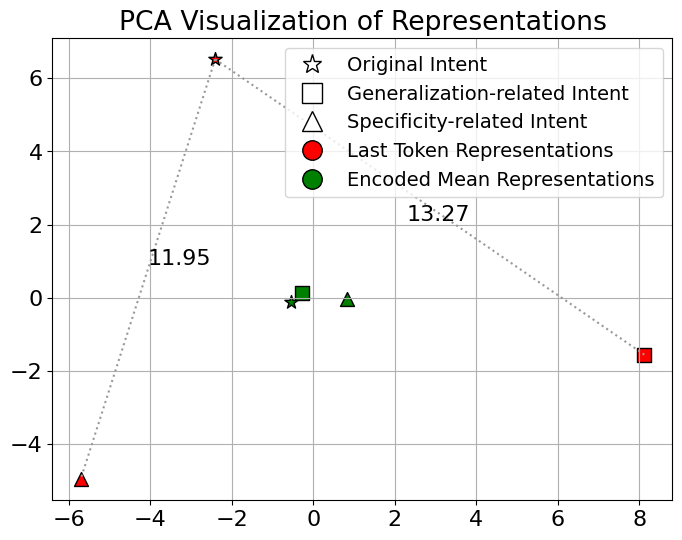

: 

In [6]:

file_name = "./results/agrace_encoder_data_loo1/EditConala/CodeLlama-7b-hf_test_mean.pkl"
with open(file_name, 'rb') as f:
    datas_mean = torch.load(f)

file_name = "./results/agrace_encoder_data_loo1/EditConala/CodeLlama-7b-hf_test_last_token.pkl"
with open(file_name, 'rb') as f:
    datas_last_token = torch.load(f)

encoder_state_path = f"./results/agrace_encoder_data_loo1/EditConala/CodeLlama-7b-hf_model.layers.27.mlp.down_proj_train_eparam.pt"
encoder = MLPEncoder(datas_mean[0]['prompt_repr'].shape[0], 256)
encoder.load_state_dict(torch.load(encoder_state_path))
encoder.eval()
plot_data = 1649
sample_size=1
plt.figure(figsize=(8, 6))
plt.rcParams.update({'font.size': 16})
colors = ['r', 'g', 'b']
markers = ['*', 's', '^']

prompt_reprs = []
rephrase_prompt_reprs = []
loc_prompts_reprs = []

# Last token
data = datas_last_token[plot_data]
prompt_repr = np.array(data['prompt_repr'])
rephrase_prompt_repr = np.array(data['rephrase_prompt_repr'])
loc_prompts_repr = np.array(data['loc_prompts_reprs'][0])
distance_rewritten = euclidean(prompt_repr, rephrase_prompt_repr)
distance_neighbor = euclidean(prompt_repr, loc_prompts_repr)
print(f"rephrase_prompt_repr last token: {distance_rewritten}")
print(f"loc_prompts_reprs last token: {distance_neighbor}")
prompt_reprs.append(prompt_repr)
rephrase_prompt_reprs.append(rephrase_prompt_repr)
loc_prompts_reprs.append(loc_prompts_repr)
data_matrix = np.array([prompt_repr, rephrase_prompt_repr, loc_prompts_repr])
distance_rewritten = euclidean(prompt_repr, rephrase_prompt_repr)
distance_neighbor = euclidean(prompt_repr, loc_prompts_repr)
print(f"rephrase_prompt_repr : {distance_rewritten}")
print(f"loc_prompts_reprs: {distance_neighbor}")

# 使用PCA进行降维
pca = PCA(n_components=2)
data_pca = pca.fit_transform(data_matrix)
for i in range(3):
  for k in range(i*sample_size, (i+1)*sample_size):
        plt.scatter(data_pca[k, 0], data_pca[k, 1], color='r',edgecolors='k', s=100,  marker=markers[i])
        plt.text(data_pca[k, 0], data_pca[k, 1], f'',ha='center', va='bottom')

plt.plot([data_pca[0,0], data_pca[1,0]], [data_pca[0,1], data_pca[1,1]], ':', color='0.6')
mid_point = (data_pca[0]+data_pca[1]) / 2.5
plt.text(mid_point[0], mid_point[1], f'{distance_rewritten:.2f}', ha='left', va='bottom', color='k') 

plt.plot([data_pca[0,0], data_pca[2,0]], [data_pca[0,1], data_pca[2,1]], ':', color='0.6')
mid_point = (data_pca[0]+data_pca[2]) / 2
plt.text(mid_point[0], mid_point[1], f'{distance_neighbor:.2f}', ha='left', va='bottom', color='k') 
# mean encode
data = datas_mean[plot_data]
with torch.no_grad():
    prompt_repr = np.array(encoder(data['prompt_repr']))
    rephrase_prompt_repr = np.array(encoder(data['rephrase_prompt_repr']))
    loc_prompts_repr = np.array(encoder(data['loc_prompts_reprs'][0]))
    distance_rewritten = euclidean(prompt_repr, rephrase_prompt_repr)
    distance_neighbor = euclidean(prompt_repr, loc_prompts_repr)
    print(f"rephrase_prompt_repr mean encode: {distance_rewritten}")
    print(f"loc_prompts_reprs mean encode: {distance_neighbor}")
prompt_reprs.append(prompt_repr)
rephrase_prompt_reprs.append(rephrase_prompt_repr)
loc_prompts_reprs.append(loc_prompts_repr)

    # 将向量组合成一个矩阵
reprs = prompt_reprs + rephrase_prompt_reprs + loc_prompts_reprs
# data_matrix = np.array(reprs)
data_matrix = np.array([prompt_repr, rephrase_prompt_repr, loc_prompts_repr])
# 使用PCA进行降维
pca = PCA(n_components=2)
data_pca = pca.fit_transform(data_matrix)


for i in range(3):
  for k in range(i*sample_size, (i+1)*sample_size):
        plt.scatter(data_pca[k, 0], data_pca[k, 1], color='g', edgecolors='k', s=100,  marker=markers[i])
        plt.text(data_pca[k, 0], data_pca[k, 1],'', ha='center', va='bottom')

# 创建自定义图例
handles = [
    plt.Line2D([0], [0], marker='*', color='w', markerfacecolor='w', markersize=14, markeredgecolor='k'),
    plt.Line2D([0], [0], marker='s', color='w', markerfacecolor='w', markersize=14, markeredgecolor='k'),
    plt.Line2D([0], [0], marker='^', color='w', markerfacecolor='w', markersize=14, markeredgecolor='k'),
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='r', markersize=14, markeredgecolor='k'),
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='g', markersize=14, markeredgecolor='k'),
]
labels = [
    'Original Intent', 'Generalization-related Intent', 'Specificity-related Intent', 'Last Token Representations', 'Encoded Mean Representations'
]

plt.title('PCA Visualization of Representations')
# plt.xscale('log',base=0.8)
# plt.yscale('log',base=0.8)
# plt.xlabel('Principal Component 1', fontsize=14)
# plt.ylabel('Principal Component 2', fontsize=14)
plt.legend(handles=handles, labels=labels, fontsize=14, loc='upper right', ncol=1)
plt.grid(True)
plt.savefig("case_PCA.pdf")

## Analyze all hidden states

In [10]:
def plot_data(euc_dis_pr_res, euc_dis_pr_locs, mode, save_file_name):
        data1 = np.array(euc_dis_pr_res)
        data2 = np.array(euc_dis_pr_locs)
        data1_name = "Euc. dis. between OI and GRI"
        data2_name = "Euc. dis. between OI and SRI"
        n = len(data1)
        
        # 创建图形和坐标轴
        fig, ax = plt.subplots(figsize=(8, 6))

        # 定义平滑函数
        def smooth_data(data, sigma=5):
                return gaussian_filter1d(data, sigma)
        plt.rcParams.update({'font.size': 16})
        # 设置平滑参数
        sigma = 10  # 调整平滑程度

        # 平滑数据
        data1_smooth = smooth_data(data1, sigma)
        data2_smooth = smooth_data(data2, sigma)

        # 计算标准差
        std1 = np.std(data1)
        std2 = np.std(data2)

        # 创建x轴数据
        x = np.arange(n)

        # 绘制包络图
        ax.plot(x, data1_smooth, color='blue', linewidth=2, label=f'{data1_name} (Mean)')
        ax.fill_between(x, data1_smooth - std1, data1_smooth + std1, 
                        color='blue', alpha=0.2, label=f'{data1_name} (Envelope)')

        ax.plot(x, data2_smooth, color='red', linewidth=2, label=f'{data2_name} (Mean)')
        ax.fill_between(x, data2_smooth - std2, data2_smooth + std2, 
                        color='red', alpha=0.2, label=f'{data2_name} (Envelope)')
        if mode == "mean":
                y_line = 0.6
                ax.axhline(y=y_line, color='k', linestyle='--', linewidth=1)
                ax.annotate(f'y={y_line}', xy=(0, y_line), xytext=(10, y_line + 5),
                textcoords='offset points', arrowprops=dict(arrowstyle='->', color='k'),
                fontsize=12, color='k')
        # 设置图表标题和标签
        ax.set_title(f'Envelope Plot of Euclidean distance', fontsize=16)
        ax.set_xlabel('Data Points', fontsize=16)
        # ax.set_ylabel('Values', fontsize=14)

        # 设置x轴
        ax.set_xlim(0, n-1)
        ax.set_xticks([0, n//4, n//2, 3*n//4, n-1])
        ax.set_xticklabels(['1', f'{n//4}', f'{n//2}', f'{3*n//4}', f'{n}'])

        # 添加图例
        ax.legend(fontsize=12, loc='best')

        # 添加网格线
        ax.grid(True, linestyle='--', alpha=0.7)

        # 添加均值和标准差信息
        ax.text(0.02, 0.07, f'{data1_name} | Mean: {np.mean(data1):.2f}, Std: {std1:.2f}', 
                transform=ax.transAxes, verticalalignment='top')
        ax.text(0.02, 0.12, f'{data2_name} | Mean: {np.mean(data2):.2f}, Std: {std2:.2f}', 
                transform=ax.transAxes, verticalalignment='top')

        plt.tight_layout()
        plt.savefig(save_file_name)

In [5]:
def compute_euc_distance(datas, encoder = None):
    euc_dis_pr_res = []
    euc_dis_pr_locs = []
    for item in datas:
        prompt_repr = item['prompt_repr']
        rephrase_prompt_repr = item['rephrase_prompt_repr']
        loc_prompts_repr = item['loc_prompts_reprs'][0]
        if encoder is not None:
            euc_dis_pr_re = F.pairwise_distance(encoder(prompt_repr), encoder(rephrase_prompt_repr))
            euc_dis_pr_loc = F.pairwise_distance(encoder(prompt_repr), encoder(loc_prompts_repr))
        else:
            euc_dis_pr_re = F.pairwise_distance(prompt_repr, rephrase_prompt_repr)
            euc_dis_pr_loc = F.pairwise_distance(prompt_repr, loc_prompts_repr)
        euc_dis_pr_res.append(euc_dis_pr_re.item())
        euc_dis_pr_locs.append(euc_dis_pr_loc.item())
    return euc_dis_pr_res, euc_dis_pr_locs

Datasets: 100%|██████████| 1/1 [00:28<00:00, 28.69s/it]


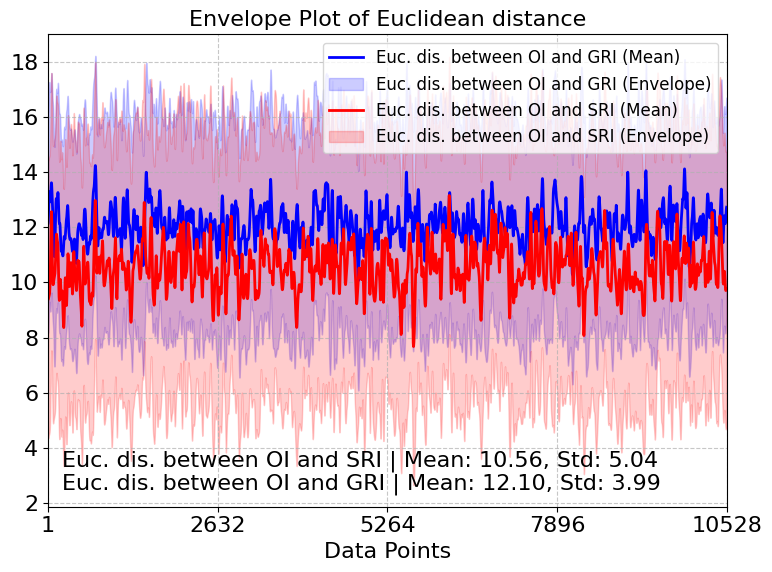

In [11]:
models = ['CodeLlama-7b-hf']
modes = ['last_token', 'mean']
datasets = ['EditConala']

# models = models[:1]
# datasets = datasets[:1]
modes = modes[:1]
split = 'test'
encoder = None



for dataset in tqdm(datasets, total=len(datasets), desc='Datasets'):
        for model_name in models:
                for mode in modes:
                        use_encoder = mode == 'mean'
                        file_name = f"./results/agrace_encoder_data_loo1/{dataset}/{model_name}_{split}_{mode}.pkl"
                        with open(file_name, 'rb') as f:
                                datas = torch.load(f)
                        if use_encoder:
                                encoder_state_path = f"./results/agrace_encoder_data_loo1/{dataset}/{model_name}_model.layers.27.mlp.down_proj_train_eparam.pt"
                                encoder = MLPEncoder(datas[0]['prompt_repr'].shape[0], 256)
                                encoder.load_state_dict(torch.load(encoder_state_path))
                                encoder.eval()
                        euc_dis_pr_res, euc_dis_pr_locs = compute_euc_distance(datas, encoder)
                        if encoder is not None:
                                fig_file = f"./results/figs/loo1_encoder_{dataset}_{model_name}_{split}_{mode}.pdf"
                        else:
                                fig_file = f"./results/figs/loo1_{dataset}_{model_name}_{split}_{mode}.pdf"
                        plot_data(euc_dis_pr_res, euc_dis_pr_locs, mode, fig_file)
